# `bar` plot

This notebook is designed to demonstrate (and so document) how to use the `shap.plots.bar` function. It uses an XGBoost model trained on the classic UCI adult income dataset (which is classification task to predict if people made over 50k in the 90s).

In [14]:
import xgboost

import shap

# train XGBoost model
X, y = shap.datasets.adult()
X.plot
model = xgboost.XGBClassifier().fit(X, y)

# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

InvalidIndexError: (slice(None, None, None), slice(None, 5, None))

## Global bar plot

Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

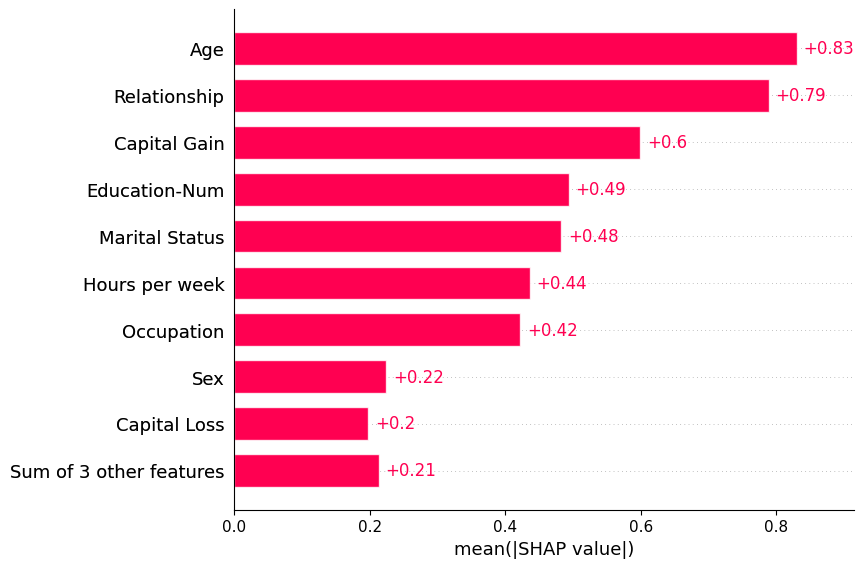

In [ ]:
shap.plots.bar(shap_values)

By default the bar plot only shows a maximum of ten bars, but this can be controlled with the `max_display` parameter:

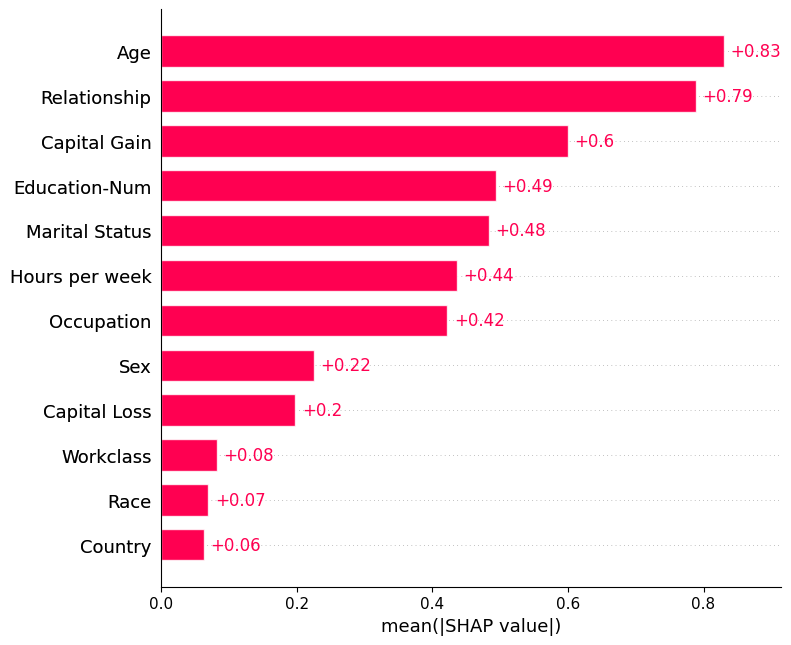

In [ ]:
shap.plots.bar(shap_values, max_display=12)

## Local bar plot

Passing a row of SHAP values to the bar plot function creates a local feature importance plot, where the bars are the SHAP values for each feature. Note that the feature values are show in gray to the left of the feature names.

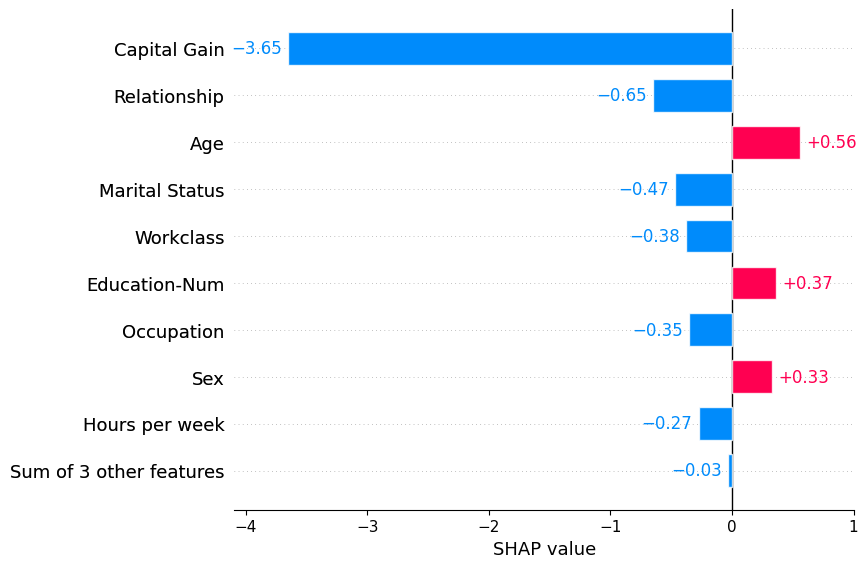

In [ ]:
shap.plots.bar(shap_values[0])

## Cohort bar plot

Passing a dictionary of Explanation objects will create a multiple-bar plot with one bar type for each of the cohorts represented by the explanation objects. Below we use this to plot a global summary of feature importance seperately for men and women.

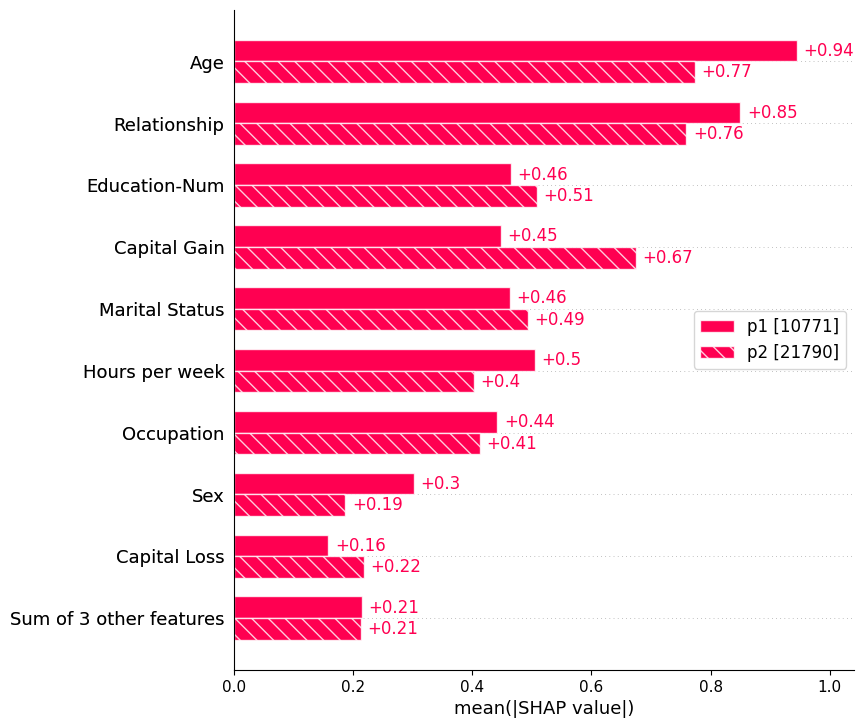

In [ ]:
sex = [
    "p1" if shap_values[i, "Sex"].data == 0 else "p2"
    for i in range(shap_values.shape[0])
]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

We can also use the auto-cohort feature of Explanation objects to create a set of cohorts using a decision tree. Calling `Explanation.cohorts(N)` will create N cohorts that optimally separate the SHAP values of the instances using a sklearn DecisionTreeRegressor. If we do this for the adult census data then we will see a clear separation between those with low vs. high captial gain. Note that the number in brackets is the number of instances in each cohort.

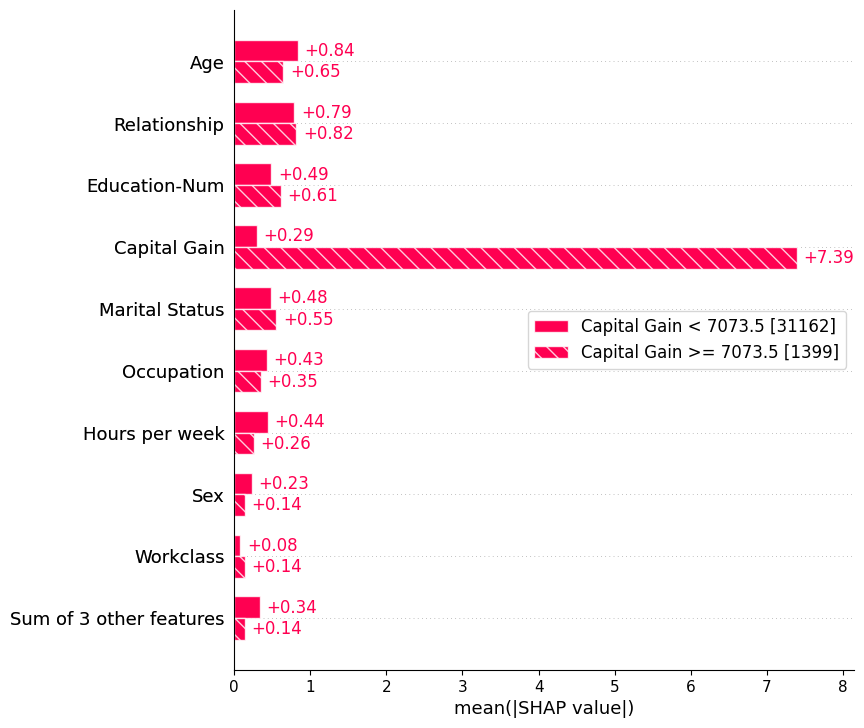

In [ ]:
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

## Using feature clustering

Often features in datasets are partially or fully redundant with each other. Where redudant means that a model could use either feature and still get same accuracy. To find these features practitioners will often compute correlation matrices among the features, or use some type of clustering method. When working with SHAP we recommend a more direct approach that measures feature redundancy through model loss comparisions. The `shap.utils.hclust` method can do this and build a hierarchical clustering of the feature by training XGBoost models to predict the outcome for each pair of input features. For typical tabular dataset this results in much more accurate measures of feature redundancy than you would get from unsupervised methods like correlation.

Once we compute such a clustering we can then pass it to the bar plot so we can simultainously visualize both the feature redundancy structure and the feature importances. Note that by default we don't show all of the clustering structure, but only the parts of the clustering with distance < 0.5. Distance in the clustering is assumed to be scaled roughly between 0 and 1, where 0 distance means the features perfectly redundant and 1 means they are completely independent. In the plot below we see that only relationship and marital status have more that 50% redundany, so they are the only features grouped in the bar plot:

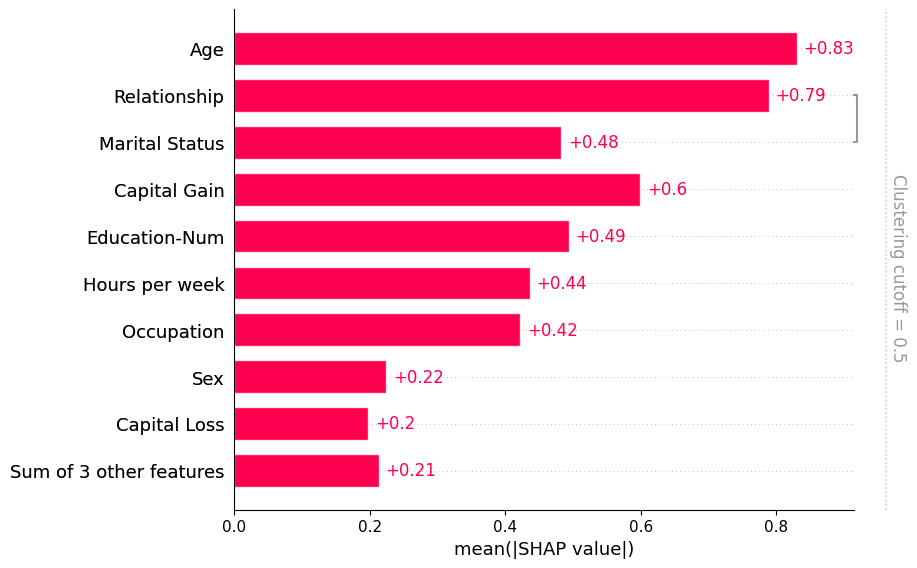

In [ ]:
clustering = shap.utils.hclust(
    X, y
)  # by default this trains (X.shape[1] choose 2) 2-feature XGBoost models
shap.plots.bar(shap_values, clustering=clustering)

If we want to see more of the clustering structure we can adjust the `cluster_threshold` parameter from 0.5 to 0.9. Note that as we increase the threshold we constrain the ordering of the features to follow valid cluster leaf orderings. The bar plot sorts each cluster and sub-cluster feature importance values in that cluster in an attempt to put the most important features at the top.

In [ ]:
shap.plots.bar(shap_values, clustering=clustering, cluster_threshold=0.9)

TypeError: bar() got an unexpected keyword argument 'cluster_threshold'

Note that some explainers use a clustering structure during the explanation process. They do this both to avoid perturbing features in unrealistic ways while explaining a model, and for the sake of computational performance. When you compute SHAP explanations using these methods they come with a clustering included in the Explanation object. When the bar plot find such a clustering it uses it without you needing to explicitly pass it through the `clustering` parameter:

In [ ]:
# only model agnostic methods support shap.maskers.TabularPartitions right now so we wrap our model as a function
def f(x):
    return model.predict(x, output_margin=True)


# define a partition masker that uses our clustering
masker = shap.maskers.Partition(X, clustering=clustering)

# explain the model again
explainer = shap.Explainer(f, masker)
shap_values_partition = explainer(X[:100])

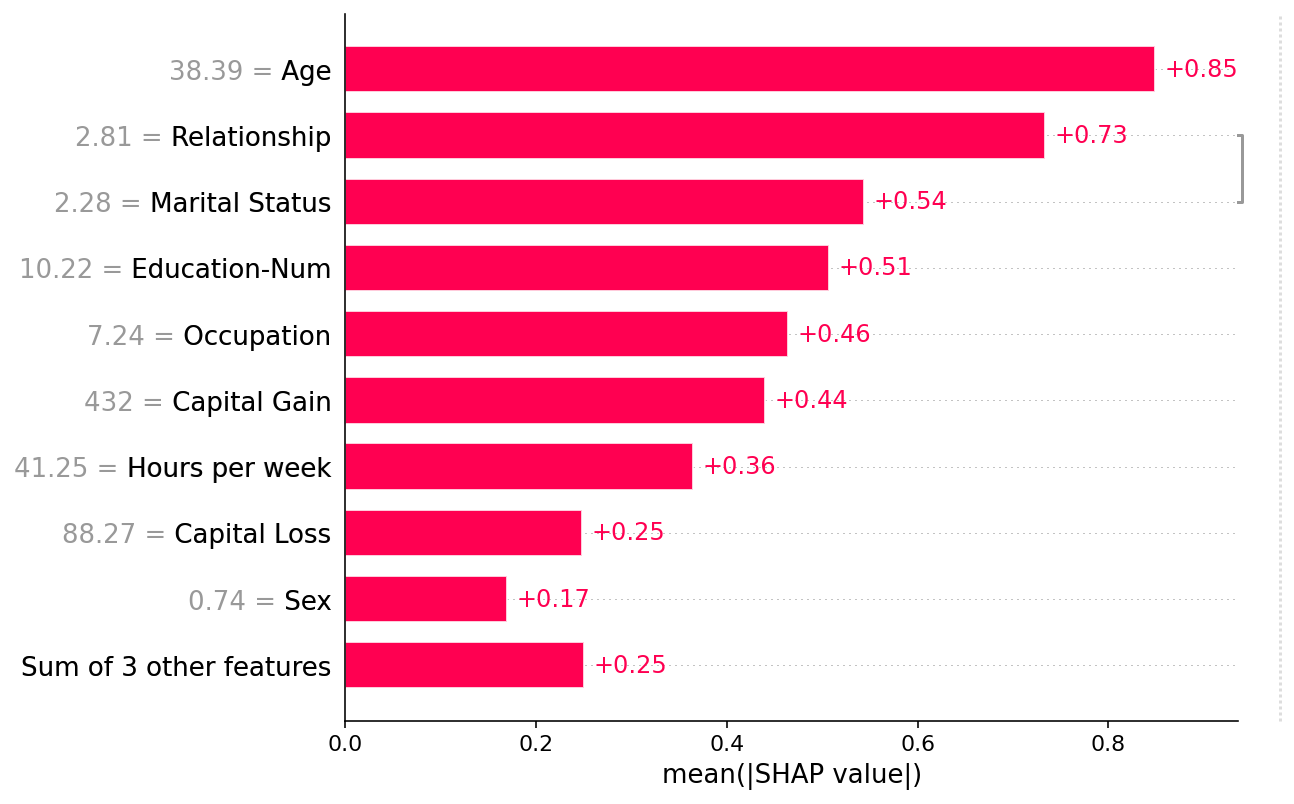

In [ ]:
shap.plots.bar(shap_values_partition)

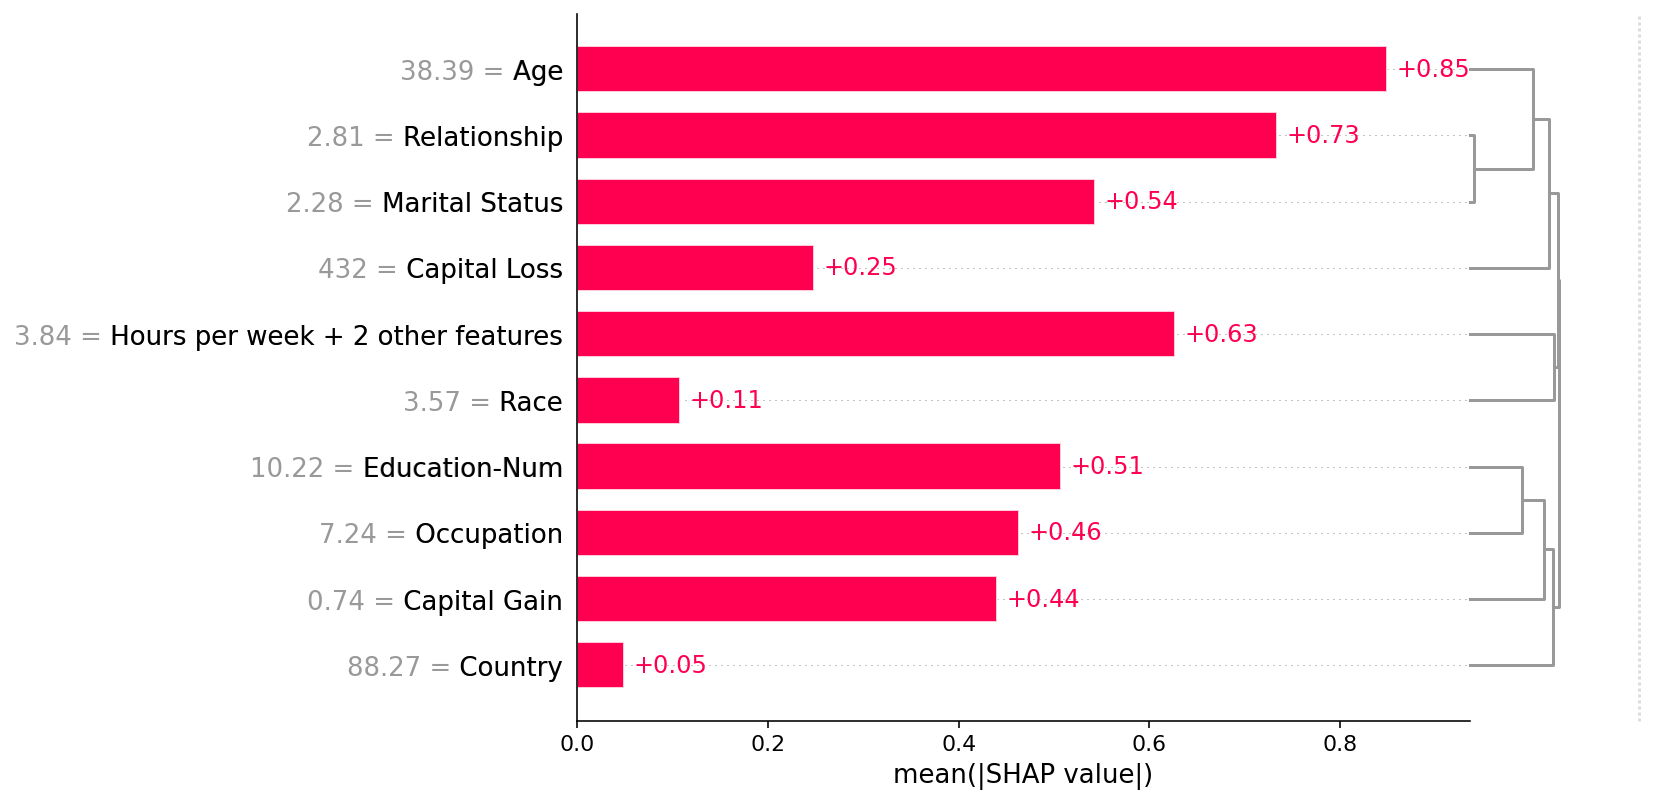

In [ ]:
shap.plots.bar(shap_values_partition, cluster_threshold=2)

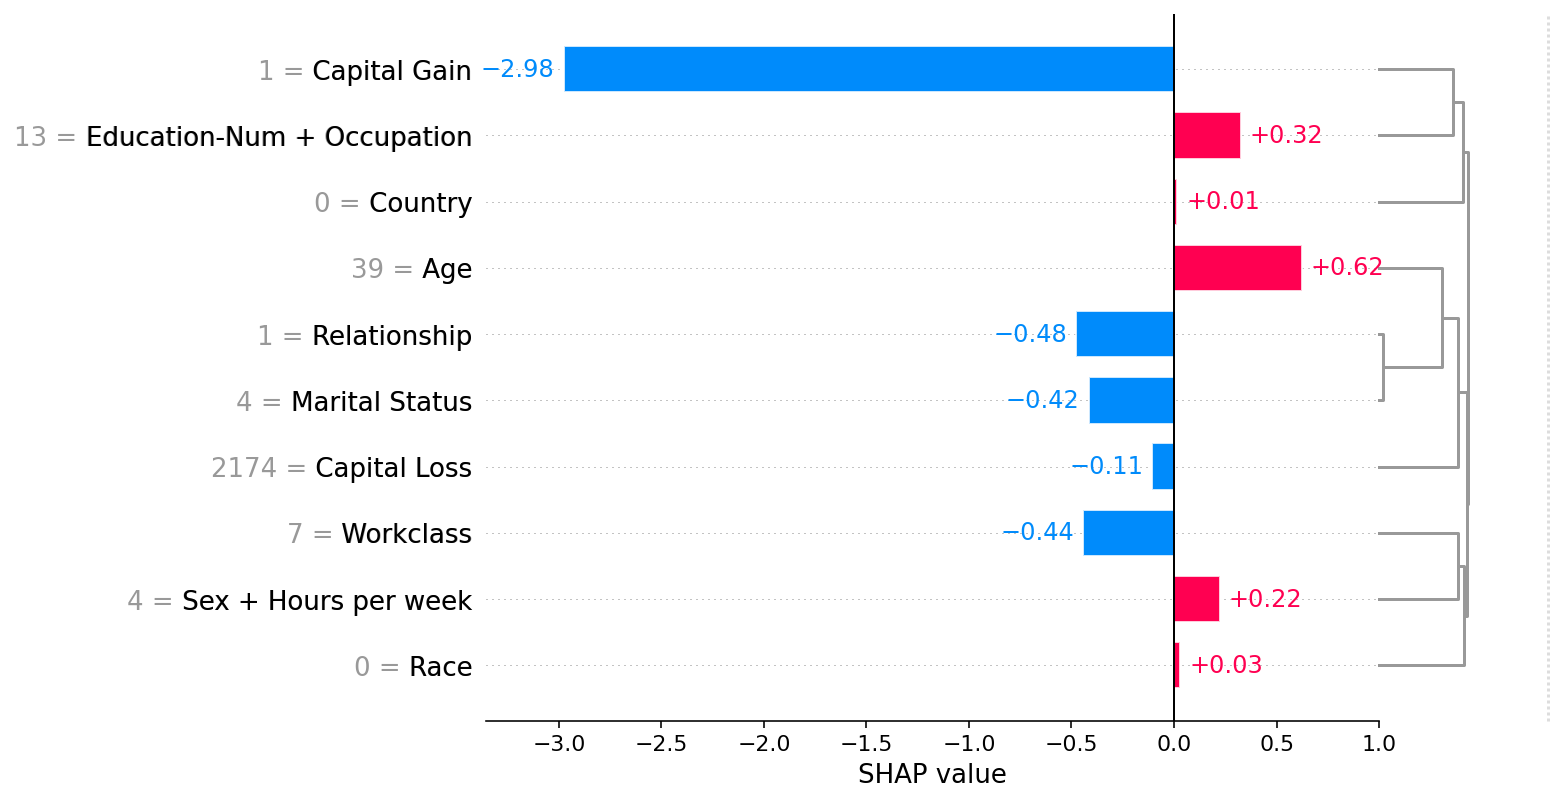

In [ ]:
shap.plots.bar(shap_values_partition[0], cluster_threshold=2)

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 